<a href="https://colab.research.google.com/github/Pierre-Cortambert/STA203/blob/main/TP1_SOD333.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP: Recalage altimétrique de navigation inertielle

In [ ]:
import numpy as np # calcul numerique
import numpy.random as rnd # fonctions pseudo-aleatoires
import matplotlib.pyplot as plt # fonctions graphiques a la MATLAB
import matplotlib.animation as anim # fonctions d’animation
import scipy.io as io # fonctions pour l’ouverture des fichiers .mat de MATLAB
import math 

In [ ]:
X1MIN = -10000
X1MAX = 10000
X2MIN = -10000
X2MAX = 10000
r0 = (-6000, 2000)
v0 = (120, 0)
sigma_r0 = 100
sigma_v0 = 10
sigma_ins = 7
sigma_alt = 10
sigma_bar = 20
delta = 1
T = 100 

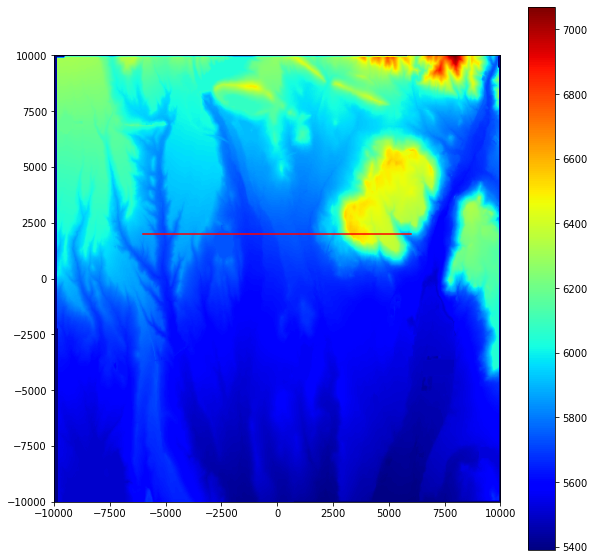

In [ ]:
map = io.loadmat('mnt.mat')['map']
N1 = map.shape[0]
N2 = map.shape[1]

traj = io.loadmat('traj.mat')
rtrue = traj['rtrue']
vtrue = traj['vtrue']

plt.figure(figsize=(10,10))
plt.imshow(map,cmap='jet',extent=[X1MIN,X1MAX,X2MIN,X2MAX])
plt.plot(rtrue[0,:],rtrue[1,:],'r-')
plt.colorbar()
plt.show()

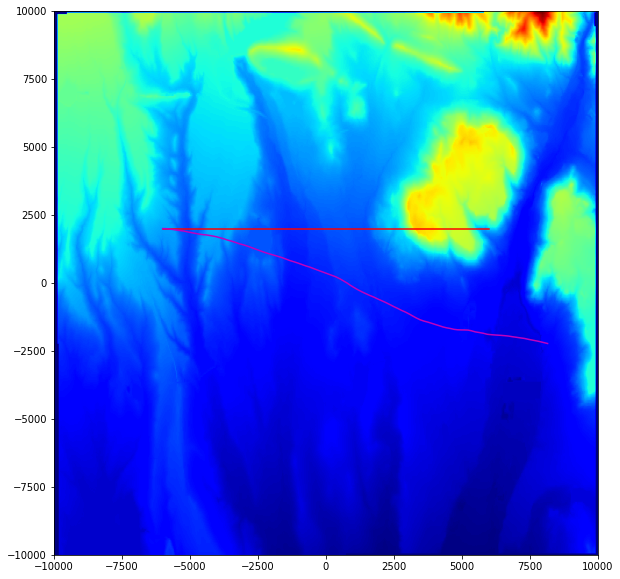

In [ ]:
a_INS = io.loadmat('ins.mat')['a_INS']

r_INS = np.zeros(rtrue.shape)
v_INS = np.zeros(vtrue.shape)
r_INS[:,0] = r0
v_INS[:,0] = v0

nmax = len(rtrue[0,:])

for k in range(1,nmax):
    r_INS[:,k] = r_INS[:,k-1]+delta*v_INS[:,k-1]
    v_INS[:,k] = v_INS[:,k-1]+delta*a_INS[:,k-1]
    
plt.figure(figsize=(10,10))
plt.imshow(map,cmap='jet',extent=[X1MIN,X1MAX,X2MIN,X2MAX])
plt.plot(rtrue[0,:],rtrue[1,:],'r-')
plt.plot(r_INS[0,:],r_INS[1,:],'m-')
plt.show()

On a :

$$\left(\begin{array}{c}
r_{k}^{\mathrm{INS}} \\
v_{k}^{\mathrm{INS}}
\end{array}\right)=\left(\begin{array}{cc}
I_{2} & \Delta I_{2} \\
0 & I_{2}
\end{array}\right)\left(\begin{array}{c}
r_{k-1}^{\mathrm{INS}} \\
v_{k-1}^{\mathrm{INS}}
\end{array}\right)+\Delta\left(\begin{array}{c}
0 \\
a_{k}^{\mathrm{INS}}
\end{array}\right) \quad \text { avec } \quad\left(\begin{array}{c}
r_{0}^{\mathrm{INS}} \\
v_{0}^{\mathrm{INS}}
\end{array}\right)=\left(\begin{array}{c}
r_{0} \\
v_{0}
\end{array}\right) \quad (1)$$

et

$$\left(\begin{array}{c}
r_{k} \\
v_{k}
\end{array}\right)=\left(\begin{array}{cc}
I_{2} & \Delta I_{2} \\
0 & I_{2}
\end{array}\right)\left(\begin{array}{c}
r_{k-1} \\
v_{k-1}
\end{array}\right)+\Delta\left(\begin{array}{c}
0 \\
a_{k}
\end{array}\right) \quad \quad (2)$$

---

En effectuant $(2)-(1)$, on obtient :

$$\left(\begin{array}{c}
\delta r_{k} \\
\delta v_{k}
\end{array}\right)=\left(\begin{array}{cc}
I_{2} & \Delta I_{2} \\
0 & I_{2}
\end{array}\right)\left(\begin{array}{c}
\delta r_{k-1} \\
\delta v_{k-1}
\end{array}\right)-\Delta\left(\begin{array}{c}
0 \\
w_{k}^{\mathrm{INS}}
\end{array}\right) \quad \text { avec } \quad\left(\begin{array}{c}
\delta r_{0} \\
\delta v_{0}
\end{array}\right)=\left(\begin{array}{l}
0 \\
0
\end{array}\right)$$

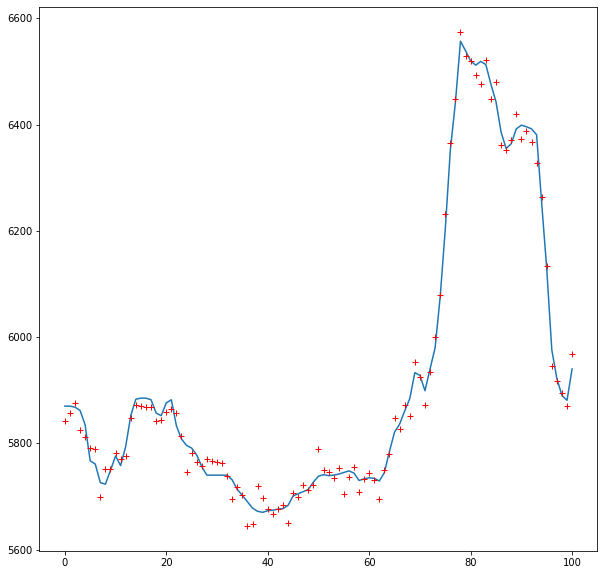

In [ ]:
def real_height(x1, x2):
    return map[(X1MAX-x1)*N1//(X1MAX-X1MIN), (x2-X2MIN)*N2//(X2MAX-X2MIN)]

h = []
for i in range(nmax) :
    h.append(real_height(rtrue[1,i], rtrue[0,i]))
    
h_ALT = io.loadmat('alt.mat')['h_ALT'][0]

plt.figure(figsize=(10,10))
plt.plot(h)
plt.plot(h_ALT, 'r+')
plt.show()

La hauteur du relief survolé à l'instant $t_k$ déduite à partir des mesures fournies par le radio-altimètre et par le baromètre est : $h_{k}^{\mathrm{ALT}} = z_{k}^{\mathrm{BAR}} - d_{k}^{\mathrm{ALT}}  =h\left(r_{k}\right)+w_{k}^{\mathrm{BAR}}-w_{k}^{\mathrm{ALT}}$

Or puisque $r_k = r_k^{\mathrm{INS}} + \delta_k$, alors :  $h_{k}^{\mathrm{ALT}}=h\left(r_{k}^{\mathrm{INS}}+\delta r_{k}\right)+w_{k}^{\mathrm{BAR}}-w_{k}^{\mathrm{ALT}}$



Expression de la fonction de vraisemblance :
$g_k(x) = q_k^V (Y_k - h_k(x))$

$g_{k}(r_k) = q_{k}^{V}(h_{k}^{\mathrm{ALT}}-h(r_k))$

$g_{k}(r_k) = q_{k}^{V}(h(r_{k}^{\mathrm{INS}}+\delta r_{k})+w_{k}^{\mathrm{BAR}}-w_{k}^{\mathrm{ALT}}-h(r_k))$

$\sigma^2 \equiv \sigma_{BAR}^2 + \sigma_{ALT}^2\\
g_k \sim N(0, \sigma^2)$

$$g_k(r) = exp\left(-\frac{1}{2}\left(\frac{h_k^{\mathrm{ALT}} -h(r)}{\sigma}\right)^2\right)$$

fonction Python 
Permet de simuler rapidement un échantillon distribué selon une loi discrète donnée, et qui sera utilisée dans ce TP pour réaliser la redistribution multinomiale.


In [ ]:
# definition d'une fonction donnant les indices des ancetres dans la redistribution multinomiale
def resampling_multi(w,N):
    u_tild = np.zeros((N))
    expo = np.zeros((N))
    alpha = np.zeros((N))
    u_ord = np.zeros((N))
    u = np.zeros((N+1))
    s = np.zeros((N))
#
    w = w/w.sum()
    s = np.cumsum(w)
    u_tild = rnd.uniform(0,1,N)
#
    for i in range(N):
        alpha[i] = u_tild[i]**(1/float(i+1)) #u_tild : uniformes
    alpha = np.cumprod(alpha) #alpha : meme distribution que des alphas triees
    u_ord = alpha[N-1]/alpha 
    u = np.append(u_ord,float("inf"))
#
    ancestor = np.zeros(N,dtype=int)
    offsprings = np.zeros(N,dtype=int)
    i = 0
    for j in range(N):
        o = 0
        while u[i]<=s[j]:
            ancestor[i] = j
            i = i+1
            o = o+1
        offsprings[j] = o
    return ancestor

In [ ]:
#implementation fonction de vraissemblance
def g(k,r):
  return np.exp(-0.5*((h_ALT[k]-real_height(r[0],r[1])**2)/(sigma_alt**2+sigma_bar**2)))




In [ ]:
def SIR(r,k):
  

  g_k=g(k,r)